In [ ]:
import numpy as np
import random
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable  
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

from pathlib import Path
import matplotlib.pyplot as plt

import sklearn

device = "cpu"
#device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


# Load Train data

In [ ]:
def load(paths,initial='clients'):
    
    data = list()
    labels = list()
    
    data_folder = Path("./Data/")
    
    client_names = ['{}_{}'.format(initial, i+1) for i in range(len(paths))]
    
    total_clients={client_names[i] : [] for i in range(len(client_names))}
    
    # loop over the input
    for j in range(len(paths)):
        
        # load the data
        target = pd.read_csv(data_folder / paths[j], usecols=[2, 5],
                             index_col=0, header=0)
        target=target.loc["20200801":"20200830"][:]
        
        target=target.to_numpy()

        #sc = preprocessing.MinMaxScaler()
        #target = sc.fit_transform(target)
        #sc = preprocessing.StandardScaler().fit(target)
        #target = sc.transform(target)
        
        #target=target.values.tolist()
        
        #total_clients[client_names[j]]=list(zip((Data, target)))
        
        total_clients[client_names[j]]=target
        
        #{client_names[i] : list(zip((Data, target)))}
        
        
    return  total_clients

#Define load paths and load train data

In [ ]:
#Cluster1
#data_paths=['building_2_.csv','building_3_.csv','building_12_.csv','building_18_.csv','building_26_.csv','building_37_.csv','building_53_.csv',
#            'building_68_.csv','building_54_.csv','building_78_.csv','building_16_.csv']


#Cluster 2
#data_paths=['building_1_.csv','building_7_.csv','building_9_.csv','building_10_.csv','building_11_.csv','building_44_.csv','building_48_.csv','building_56_.csv',
#            'building_76_.csv']

#Cluster 3
#data_paths=['building_4_.csv','building_5_.csv','building_13_.csv','building_17_.csv','building_23_.csv','building_24_.csv','building_27_.csv','building_34_.csv',
  #          'building_42_.csv','building_43_.csv','building_57_.csv','building_61_.csv','building_66_.csv','building_69_.csv','building_81_.csv']

#Cluster 4
data_paths=['building_19_.csv','building_22_.csv','building_25_.csv','building_29_.csv','building_30_.csv','building_32_.csv','building_35_.csv','building_36_.csv',
            'building_38_.csv','building_41_.csv','building_62_.csv','building_63_.csv','building_64_.csv','building_65_.csv','building_71_.csv','building_72_.csv',
            'building_73_.csv']

clients=load(data_paths,initial='clients')


In [ ]:
client_names = ['{}_{}'.format('clients', i+1) for i in range(len(data_paths))]
aggregate_load=0

for i in range(len(data_paths)):
  aggregate_load+=clients[client_names[i]]

In [ ]:
def sliding_windows(data, aggregate_load, seq_length, pred_length):
    x = []
    y = []
    x_aggregate=[]
    y_aggregate=[]
    
    count=int(((len(data)-seq_length)/pred_length))

    for i in range(count):
        
        _x = data[i*pred_length:(i*pred_length+seq_length)]
        _y = data[i*pred_length+seq_length:i*pred_length+seq_length+pred_length]

        aggregate_x=aggregate_load[i*pred_length:(i*pred_length+seq_length)]
        aggregate_y=aggregate_load[i*pred_length+seq_length:i*pred_length+seq_length+pred_length]

        x.append(_x)
        y.append(_y)

        x_aggregate.append(aggregate_x)
        y_aggregate.append(aggregate_y)

    return np.array(x),np.array(y),np.array(x_aggregate),np.array(y_aggregate)



#process and batch the test data for each client

client_names = ['{}_{}'.format('clients', i+1) for i in range(len(data_paths))]

x=dict()
y=dict()

seq_length = 48
pred_length = 24

for i in range(len(data_paths)):
    
    x[client_names[i]], y[client_names[i]], x_aggregate, y_aggregate = sliding_windows(clients[client_names[i]], aggregate_load, seq_length, pred_length)
    


In [ ]:
train_size = int(len(y[client_names[i]]) * 0.67)
test_size = len(y[client_names[i]]) - train_size

dataX = dict()
dataY= dict()

trainX= dict()
trainY= dict()

testX= dict()
testY= dict()

for i in range(len(data_paths)):
    
    dataX[client_names[i]] = Variable(torch.Tensor(np.array(x[client_names[i]]))).to(device)
    dataY[client_names[i]] = Variable(torch.Tensor(np.array(y[client_names[i]]))).to(device)

    trainX[client_names[i]] = Variable(torch.Tensor(np.array(x[client_names[i]][0:train_size]))).to(device)
    trainY[client_names[i]] = Variable(torch.Tensor(np.array(y[client_names[i]][0:train_size]))).to(device)

    testX[client_names[i]] = Variable(torch.Tensor(np.array(x[client_names[i]][train_size:len(x[client_names[i]])]))).to(device)
    testY[client_names[i]] = Variable(torch.Tensor(np.array(y[client_names[i]][train_size:len(y[client_names[i]])]))).to(device)
    
    testY[client_names[i]] = testY[client_names[i]][:,:,0]
    trainY[client_names[i]] = trainY[client_names[i]][:,:,0]




trainX_aggregate = Variable(torch.Tensor(np.array(x_aggregate[0:train_size]))).to(device)
trainY_aggregate = Variable(torch.Tensor(np.array(y_aggregate[0:train_size]))).to(device)

testX_aggregate = Variable(torch.Tensor(np.array(x_aggregate[train_size:len(x[client_names[i]])]))).to(device)
testY_aggregate = Variable(torch.Tensor(np.array(y_aggregate[train_size:len(y[client_names[i]])]))).to(device)

testY_aggregate = testY_aggregate[:,:,0]
trainY_aggregate = trainY_aggregate[:,:,0]

# FedAvg Method

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    
    #first calculate the total training data points across clinets
    global_count = sum([clients_trn_data[client_name2][0].shape[0] for client_name2 in client_names])
    # get the total number of data points held by a client
    local_count = clients_trn_data[client_name][0].shape[0]
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = scalar*weight
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad=sum(scaled_weight_list)
        
    return avg_grad

# Define the MLP Structure

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x


class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size1, hidden_size2, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size1,
                            num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size1)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size1)).to(device)
        
        self.lstm.flatten_parameters()


        
        # Propagate input through LSTM
        out, _ = self.lstm(x, (h_0, c_0))
        out = out[:, -1, :]
        #h_out = h_out.view(-1, self.hidden_size1)
        
        out = self.fc1(out)
        out = self.fc2(out)
        #out = torch.clip(out, 0)
        
        return out

## Training Loop

In [ ]:
#initialize global model
#smlp_global = SimpleMLP()
input_size = 1
hidden_size1 = 68
hidden_size2 = 105
num_layers = 1

num_classes = 24

outliers = []
rounds_list = dict()
local_model = dict()
optimizer=dict()
loss_clients=dict()
every_round_loss=dict()
total_mse=dict()

for client in client_names:
    local_model[client]=LSTM(num_classes, input_size, hidden_size1, hidden_size2, num_layers).to(device)
    optimizer[client]= torch.optim.Adam(local_model[client].parameters(), lr=0.01)
    loss_clients[client]=[]
    every_round_loss[client]=[]
    total_mse[client]=[]


global_model = LSTM(num_classes, input_size, hidden_size1, hidden_size2, num_layers).to(device)
optimizer2 = torch.optim.Adam(global_model.parameters(), lr=0.01)

loss_fn = nn.MSELoss()
#mse=sklearn.metrics.mean_squared_error(y_test, pred)
#mape=sklearn.metrics.mean_absolute_percentage_error(y_test, pred)
#global_model.compile(loss=loss, 
#                      optimizer=optimizer, 
#                      metrics=metrics)

comms_round = 291

aggregate_losses=[]
aggregate_losses_train=[]



mean_mse=[]

import tqdm

EPOCHS  = 1


loss_ = []

        
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights1 = global_model.lstm.weight_hh_l0.data
    global_weights2 = global_model.lstm.weight_ih_l0.data
    global_weights3 = global_model.fc1.weight.data
    global_weights4 = global_model.fc2.weight.data
    #initial list to collect local model weights after scalling
    scaled_local_weight_list1 = list()
    scaled_local_weight_list2 = list()
    scaled_local_weight_list3 = list()
    scaled_local_weight_list4 = list()

    #randomize client data - using keys
    client_names= list(trainX.keys())
    #random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        
        
        
        
        #set local model weight to the weight of the global model
        local_model[client].lstm.weight_hh_l0.data=global_weights1
        local_model[client].lstm.weight_ih_l0.data=global_weights2
        local_model[client].fc1.weight.data=global_weights3
        local_model[client].fc2.weight.data=global_weights4

        
        #fit local model with client's data
        #tqdm.trange(EPOCHS)
        for epoch in range(EPOCHS):
            optimizer[client].zero_grad()
            y_pred = local_model[client](trainX[client])
            loss = loss_fn(y_pred, trainY[client])   #loss(input, target)
            loss_.append(loss)
            loss.backward()
            optimizer[client].step()
        loss_clients[client].append(loss_)
        every_round_loss[client]=loss
        loss_=[]

        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(trainX, client)
        scaled_weights1 = scale_model_weights(local_model[client].lstm.weight_hh_l0.data, scaling_factor)
        scaled_weights2 = scale_model_weights(local_model[client].lstm.weight_ih_l0.data, scaling_factor)
        scaled_weights3 = scale_model_weights(local_model[client].fc1.weight.data, scaling_factor)
        scaled_weights4 = scale_model_weights(local_model[client].fc2.weight.data, scaling_factor)
        scaled_local_weight_list1.append(scaled_weights1)
        scaled_local_weight_list2.append(scaled_weights2)
        scaled_local_weight_list3.append(scaled_weights3)
        scaled_local_weight_list4.append(scaled_weights4)
        
        #clear session to free memory after each communication round
        #K.clear_session()
        
        
    #outliers = detect_outlier(comm_round,loss_clients,prev_loss)
    #if comm_round>0:
   #  if comm_round%20 == 0:
    #      if comm_round == 20:
    #        prev_loss=loss_clients['clients_1'][comm_round][0]
     #       rounds_list[comm_round]=loss_clients['clients_1'][comm_round][0]
     #       #prev_loss = every_round_loss
     #       #rounds_list[comm_round]=every_round_loss
     #     else:
      #      for clients2 in client_names:
      #        if loss_clients[clients2][comm_round][0] >= 1.05 * prev_loss[clients2]:
      #          outliers.append(clients2)
      #          prev_loss[clients2]=loss_clients[clients2][comm_round][0]
      #      rounds_list[comm_round]=loss_clients[clients2][comm_round][0]
            #prev_loss = every_round_loss
            #rounds_list[comm_round]=every_round_loss
            
    if comm_round>0:
        if comm_round%20 == 0:
            for clients2 in client_names:
                if loss_clients[clients2][comm_round][0] >= 1.3 * loss_clients[clients2][comm_round-20][0]:
                    outliers.append(clients2)


    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights1 =sum_scaled_weights(scaled_local_weight_list1)
    #sum_scaled_weights(scaled_local_weight_list1)
     
    average_weights2 = sum_scaled_weights(scaled_local_weight_list2)
    average_weights3 = sum_scaled_weights(scaled_local_weight_list3)
    average_weights4 = sum_scaled_weights(scaled_local_weight_list4)

    #update global model 
    global_model.lstm.weight_hh_l0.data=average_weights1
    global_model.lstm.weight_ih_l0.data=average_weights2
    global_model.fc1.weight.data=average_weights3
    global_model.fc2.weight.data=average_weights4

    #test global model and print out metrics after each communications round
    for client in client_names:
        #loss, mse = global_model.evaluate(clients_batched_test[client], verbose=2)
        pred=global_model(testX[client])
        
        
        #total_mse.append(mse(clients_test[client][1], pred))
        total_mse[client].append(loss_fn(pred, testY[client]))   #loss(input, target)
    #mean_mse.append(np.mean(total_mse))
    #total_mse=[]
    agg_pred=global_model(testX_aggregate)
    #agg_loss = mse(y_test, pred*len(client_names))
    #agg_pred=pred*len(client_names)
    agg_loss = loss_fn(agg_pred, testY_aggregate)
    #agg_loss1 = sklearn.metrics.mean_squared_error(agg_pred.cpu().data.numpy(), y_test.cpu().data.numpy())
    #sklearn.metrics.mean_squared_error(y_test, agg_pred)
    aggregate_losses.append(agg_loss)


    #loss of training
    agg_pred_train=global_model(trainX_aggregate)
    #agg_pred_train=pred_train*len(client_names)
    agg_loss_train= loss_fn(agg_pred_train,trainY_aggregate)
    aggregate_losses_train.append(agg_loss_train)

In [ ]:
outliers

['clients_11', 'clients_5', 'clients_9', 'clients_11', 'clients_9']

#Model Evaluation

In [ ]:
MSE_of_clients1=[]
MSE_of_clients2=[]
MAPE_of_clients=[]

for client in client_names:
  pred_test_clients=global_model(testX[client])
  MSE_of_clients1.append(loss_fn(pred_test_clients, testY[client]))
  MSE_of_clients2.append(sklearn.metrics.mean_squared_error(testY[client].cpu().data.numpy(), pred_test_clients.cpu().data.numpy()))
  MAPE_of_clients.append(sklearn.metrics.mean_absolute_percentage_error(testY[client].cpu().data.numpy(), pred_test_clients.cpu().data.numpy()))




In [ ]:
MSE_of_clients2

[0.22964513,
 0.6292591,
 0.68056554,
 0.09659948,
 0.5325926,
 0.48655894,
 0.17498751,
 0.21131365,
 0.032404702,
 0.039561912,
 0.14659028]

In [ ]:
MSE_of_clients_train=[]
MAPE_of_clients_train=[]

for client in client_names:
  pred_train_clients=global_model(trainX[client])
  MSE_of_clients_train.append(sklearn.metrics.mean_squared_error(trainY[client].cpu().data.numpy(), pred_train_clients.cpu().data.numpy()))
  MAPE_of_clients_train.append(sklearn.metrics.mean_absolute_percentage_error(trainY[client].cpu().data.numpy(), pred_train_clients.cpu().data.numpy()))


In [ ]:
MAPE_of_clients

[1.0693659,
 1.2173918,
 0.5997849,
 1.0283563,
 0.58619684,
 0.84881717,
 0.69008493,
 1.0309201,
 3.1417453,
 1.4065081,
 450890770000000.0]

In [ ]:
np.mean(MAPE_of_clients_train)

31657139000000.0

In [ ]:
MAPE_of_clients_train

[0.94052106,
 0.79711646,
 0.556601,
 0.9342044,
 0.53362226,
 0.8908901,
 0.7292252,
 1.0064319,
 3.2661579,
 1.4265146,
 348228530000000.0]

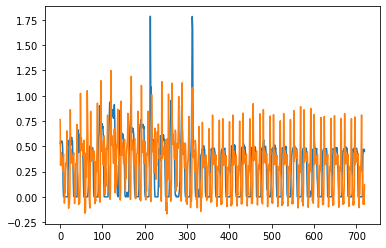

In [ ]:
pred_test_clients=global_model(testX['clients_11'])
plt.plot(testY['clients_11'].view(len(testY['clients_3'][:])*len(testY['clients_3'][0,:])).cpu().data.numpy())
plt.plot(pred_test_clients.view(len(testY['clients_3'][:])*len(testY['clients_3'][0,:])).cpu().data.numpy())


In [ ]:
agg_pred_test=global_model(testX_aggregate)

agg_loss_test = loss_fn(agg_pred_test, testY_aggregate)

agg_pred_train=global_model(trainX_aggregate)

agg_loss_train= loss_fn(agg_pred_train,trainY_aggregate)

In [ ]:
agg_pred_test_MSE=sklearn.metrics.mean_squared_error(agg_pred_test.cpu().data.numpy(), testY_aggregate.cpu().data.numpy())
agg_pred_test_MAPE=sklearn.metrics.mean_absolute_percentage_error(agg_pred_test.cpu().data.numpy(), testY_aggregate.cpu().data.numpy())

agg_pred_train_MSE=sklearn.metrics.mean_squared_error(agg_pred_train.cpu().data.numpy(),trainY_aggregate.cpu().data.numpy())
agg_pred_train_MAPE=sklearn.metrics.mean_absolute_percentage_error(agg_pred_train.cpu().data.numpy(),trainY_aggregate.cpu().data.numpy())

print(agg_pred_test_MSE,agg_pred_test_MAPE,agg_pred_train_MSE,agg_pred_train_MAPE)

121.19993 5.7657814 83.43775 4.1317773


In [ ]:
agg_pred_test=global_model(testX_aggregate/len(client_names))*len(client_names)

agg_loss_test = loss_fn(agg_pred, testY_aggregate)

agg_pred_train=global_model(trainX_aggregate/len(client_names))*len(client_names)

agg_loss_train= loss_fn(agg_pred_train,trainY_aggregate)

In [ ]:
agg_pred_test_MSE=sklearn.metrics.mean_squared_error(agg_pred_test.cpu().data.numpy(), testY_aggregate.cpu().data.numpy())
agg_pred_test_MAPE=sklearn.metrics.mean_absolute_percentage_error(agg_pred_test.cpu().data.numpy(), testY_aggregate.cpu().data.numpy())

agg_pred_train_MSE=sklearn.metrics.mean_squared_error(agg_pred_train.cpu().data.numpy(),trainY_aggregate.cpu().data.numpy())
agg_pred_train_MAPE=sklearn.metrics.mean_absolute_percentage_error(agg_pred_train.cpu().data.numpy(),trainY_aggregate.cpu().data.numpy())

print(agg_pred_test_MSE,agg_pred_test_MAPE,agg_pred_train_MSE,agg_pred_train_MAPE)

2.7182982 0.45115072 2.8752367 0.43729493


In [ ]:
torch.save(global_model, "./Data/entire_model_best.pt")
#model = torch.load("./Data/entire_model_best.pt")


In [ ]:
local_model['clients_4'].lstm.all_weights

[[Parameter containing:
  tensor([[-0.3549],
          [-1.0507],
          [-0.4264],
          [-0.4814],
          [-0.1807],
          [-0.4903],
          [ 0.1062],
          [-0.4612],
          [-0.0357],
          [-0.1507],
          [-0.3758],
          [-0.2407],
          [-0.0882],
          [-0.4176],
          [ 0.0738],
          [-0.5474],
          [-0.0122],
          [-0.3103],
          [ 0.6578],
          [-0.2446],
          [-0.2269],
          [-0.0033],
          [-0.4660],
          [-0.0070],
          [-0.6795],
          [-0.5705],
          [-0.7823],
          [ 0.3317],
          [-0.7198],
          [ 0.0914],
          [-0.0857],
          [-0.1109],
          [-0.1452],
          [-0.3726],
          [-0.6137],
          [-0.3224],
          [-0.5113],
          [-0.4779],
          [ 0.2547],
          [ 0.0775],
          [-0.1308],
          [-0.0955],
          [ 0.3420],
          [-0.3432],
          [-0.1382],
          [ 0.1343],
          

In [ ]:
torch.save(local_model, "./Data/entire_model_best.pt")
#model = torch.load("./Data/entire_model_best.pt")

#Extras

Text(0, 0.5, 'Individual Electricity Load [kWh]')

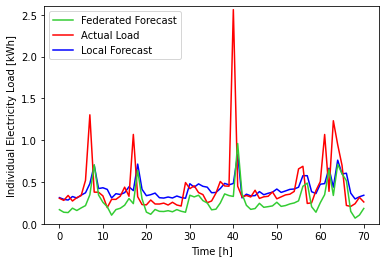

In [ ]:
y_pred = local_model['clients_1'](trainX['clients_1'])
y_pred2 = global_model(trainX['clients_1'])
plot1,=plt.plot(y_pred.cpu().data.numpy()[1:72], color='b')
plot2,=plt.plot(trainY['clients_1'][1:72].cpu().data.numpy(), color='r')
plot3,=plt.plot(y_pred2[1:72].cpu().data.numpy(), color=(0.2, 0.8, 0.2))

axes = plt.gca()
axes.set_ylim([0,2.6])
plt.legend([plot3, plot2,plot1],["Federated Forecast","Actual Load", "Local Forecast"], loc=2)


plt.xlabel("Time [h]")
plt.ylabel("Individual Electricity Load [kWh]")

#Smooth Plots

Text(0, 0.5, 'Aggregate Electricity Load [kWh]')

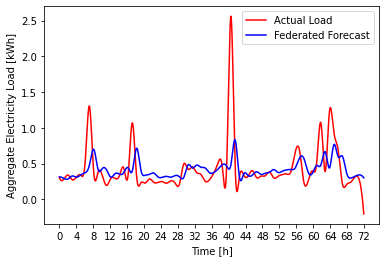

In [ ]:
from scipy.interpolate import make_interp_spline

x = np.arange(1,72)
X_Y_Spline1 = make_interp_spline(x, trainY['clients_1'][1:72].cpu().data.numpy())

X_Y_Spline2 = make_interp_spline(x, y_pred.cpu().data.numpy()[1:72])

#X_Y_Spline3 = make_interp_spline(x, pred_central)

#X_Y_Spline4 = make_interp_spline(x, total_pred)

X_ = np.linspace(1, 72, 1440)

y_train_=X_Y_Spline1(X_)

pred_=X_Y_Spline2(X_)

#pred_central_=X_Y_Spline3(X_)


#total_pred_=X_Y_Spline4(X_)


plot1, =plt.plot(y_train_, color='r', label='Actual Load')
plot2, =plt.plot(pred_, color='b', label='Federated Forecast')
#plot3, =plt.plot(pred_central_, color=(0.2, 0.8, 0.2), label='Centralized Forecast')
#plot4, =plt.plot(total_pred_, color=(0.8, 0, 1), label='Individual Forecast')

axes = plt.gca()
#axes.set_ylim([1,18])

plt.xticks([0,80, 160, 240, 320, 400, 480, 560, 640, 720, 800, 880, 960, 1040, 1120, 1200, 1280, 1360, 1440],
           ['0','4','8','12','16','20', '24', '28', '32', '36', '40', '44', '48', '52', '56', '60', '64', '68', '72'] )


plt.legend([plot1,plot2],["Actual Load", "Federated Forecast"])

plt.xlabel("Time [h]")
plt.ylabel("Aggregate Electricity Load [kWh]")

#Individual Forecast

In [ ]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size1, hidden_size2, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size1,
                            num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size1)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size1)).to(device)
        
        # Propagate input through LSTM
        out, _ = self.lstm(x, (h_0, c_0))
        out = out[:, -1, :]
        #h_out = h_out.view(-1, self.hidden_size1)
        
        out = self.fc1(out)
        out = self.fc2(out)
        out = torch.clip(out, 0)
        
        return out

In [ ]:
input_size = 1
hidden_size1 = 44
hidden_size2 = 127
num_layers = 1

num_classes = 1



local_model2 = dict()
optimizer2=dict()

for client in client_names:
    local_model2[client]=LSTM2(num_classes, input_size, hidden_size1, hidden_size2, num_layers).to(device)
    optimizer2[client]= torch.optim.Adam(local_model2[client].parameters(), lr=0.01)



loss_fn = nn.MSELoss()


EPOCHS  = 148


loss_2 = []
loss_clients2=dict()
        


#randomize client data - using keys
client_names= list(trainX.keys())
#random.shuffle(client_names)
    
#loop through each client and create new local model
for client in client_names:

  #fit local model with client's data
  #tqdm.trange(EPOCHS)
  for epoch in range(EPOCHS):
    optimizer2[client].zero_grad()
    y_pred = local_model2[client](trainX[client])
    loss = loss_fn(y_pred, trainY[client])   #loss(input, target)
    loss_2.append(loss)
    loss.backward()
    optimizer2[client].step()
  loss_clients2[client]=loss_2
  loss_2=[]
         

In [ ]:

MSE_of_clients_individual_test=[]
MAPE_of_clients_individual_test=[]

for client in client_names:
  pred_test_clients_i=local_model2[client](testX[client])
  MSE_of_clients_individual_test.append(sklearn.metrics.mean_squared_error(testY[client].cpu().data.numpy(), pred_test_clients_i.cpu().data.numpy()))
  MAPE_of_clients_individual_test.append(sklearn.metrics.mean_absolute_percentage_error(testY[client].cpu().data.numpy(), pred_test_clients_i.cpu().data.numpy()))


In [ ]:
np.mean(np.sqrt(MSE_of_clients_individual_test))

0.47462937

In [ ]:
np.mean(MAPE_of_clients_individual_test)

0.6423904

In [ ]:

MSE_of_clients_individual_train=[]
MAPE_of_clients_individual_train=[]

for client in client_names:
  pred_train_clients_i=local_model2[client](trainX[client])
  MSE_of_clients_individual_train.append(sklearn.metrics.mean_squared_error(trainY[client].cpu().data.numpy(), pred_train_clients_i.cpu().data.numpy()))
  MAPE_of_clients_individual_train.append(sklearn.metrics.mean_absolute_percentage_error(trainY[client].cpu().data.numpy(), pred_train_clients_i.cpu().data.numpy()))


In [ ]:
np.mean(MAPE_of_clients_individual_train)

0.63898546

In [ ]:
MSE_of_clients_individual_train

[0.22945131,
 0.62408215,
 0.15758026,
 0.035081454,
 0.09874,
 0.97977424,
 0.25203735,
 0.06585185]

In [ ]:
MAPE_of_clients_individual_train

[1.0, 1.0, 0.21778788, 0.3592518, 0.21471246, 1.0, 1.0, 0.32013124]

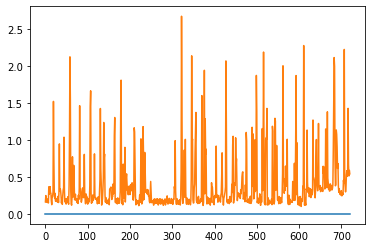

In [ ]:
plt.plot(local_model2['clients_1'](testX['clients_1']).cpu().data.numpy())
plt.plot(testY['clients_1'].cpu().data.numpy())

In [ ]:
MAPE_of_clients_individual_test

[1.0, 1.0, 0.27189866, 0.35054964, 0.24951294, 1.0, 1.0, 0.26716173]

In [ ]:
MSE_of_clients_individual_test

[0.29757303,
 0.6412734,
 0.17643565,
 0.02099794,
 0.09857034,
 0.7309843,
 0.26503623,
 0.040818553]

In [ ]:
for client in client_names:
  torch.save(local_model2[client], "./Data/"+client+".pt")
  #model = torch.load("./Data/entire_model_best.pt")

checking performance for aggregate demand prediction

In [ ]:

agg_forecast=0

for client in client_names:
  pred_test_clients_i=local_model2[client](testX[client]).cpu().data.numpy()
  agg_forecast=agg_forecast+pred_test_clients_i

MSE_aggreagte_individual_test=sklearn.metrics.mean_squared_error(testY_aggregate.cpu().data.numpy(), agg_forecast)
MAPE_aggregate_individual_test=sklearn.metrics.mean_absolute_percentage_error(testY_aggregate.cpu().data.numpy(), agg_forecast)


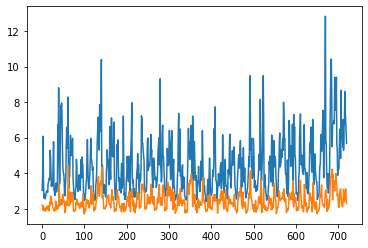

In [ ]:
plt.plot(testY_aggregate.cpu().data.numpy())
plt.plot(agg_forecast)


In [ ]:
MSE_aggreagte_individual_test

5.597774

In [ ]:
np.sqrt(MSE_aggreagte_individual_test)

2.3659616

In [ ]:
MAPE_aggregate_individual_test

0.4112947

In [ ]:

agg_forecast_train=0

for client in client_names:
  pred_train_clients_i=local_model2[client](trainX[client]).cpu().data.numpy()
  agg_forecast_train=agg_forecast_train+pred_train_clients_i

MSE_aggreagte_individual_train=sklearn.metrics.mean_squared_error(trainY_aggregate.cpu().data.numpy(), agg_forecast_train)
MAPE_aggregate_individual_train=sklearn.metrics.mean_absolute_percentage_error(trainY_aggregate.cpu().data.numpy(), agg_forecast_train)


In [ ]:
MSE_aggreagte_individual_train

6.104782

In [ ]:
np.sqrt(MSE_aggreagte_individual_train)

2.4707856

In [ ]:
MAPE_aggregate_individual_train

0.42208767

#Centralized Model

In [ ]:

input_size = 1
hidden_size1 = 44
hidden_size2 = 127
num_layers = 1

num_classes = 1




central_model=LSTM2(num_classes, input_size, hidden_size1, hidden_size2, num_layers).to(device)
optimizer3= torch.optim.Adam(central_model.parameters(), lr=0.01)


loss_fn = nn.MSELoss()



EPOCHS  = 148





    
#loop through each client and create new local model


#fit local model with client's data
#tqdm.trange(EPOCHS)
for epoch in range(EPOCHS):
  optimizer3.zero_grad()
  y_pred = central_model(trainX_aggregate)
  loss = loss_fn(y_pred, trainY_aggregate)   #loss(input, target)
  loss.backward()
  optimizer3.step()

         

In [ ]:
central_pred=central_model(testX_aggregate)

MSE_central_test=sklearn.metrics.mean_squared_error(central_pred.cpu().data.numpy(), testY_aggregate.cpu().data.numpy())

MAPE_central_test = sklearn.metrics.mean_absolute_percentage_error(central_pred.cpu().data.numpy(), testY_aggregate.cpu().data.numpy())

print(MSE_central_test, MAPE_central_test)

21.787102 1.988071e+16


In [ ]:
torch.save(central_model, "./Data/central_model_best.pt")

In [ ]:
np.sqrt(MSE_central_test)

4.6676655

In [ ]:
central_pred=central_model(trainX_aggregate)

MSE_central_train=sklearn.metrics.mean_squared_error(central_pred.cpu().data.numpy(), trainY_aggregate.cpu().data.numpy())

MAPE_central_train = sklearn.metrics.mean_absolute_percentage_error(central_pred.cpu().data.numpy(), trainY_aggregate.cpu().data.numpy())

print(MSE_central_train, MAPE_central_train)

24.283705 2.1191092e+16


In [ ]:
np.sqrt(MSE_central_train)

4.92785

In [ ]:

MSE_central_test_individual=[]
MAPE_central_test_individual=[]

for client in client_names:
  pred_test_clients_i=central_model(testX[client])
  MSE_central_test_individual.append(sklearn.metrics.mean_squared_error(testY[client].cpu().data.numpy(), pred_test_clients_i.cpu().data.numpy()))
  MAPE_central_test_individual.append(sklearn.metrics.mean_absolute_percentage_error(testY[client].cpu().data.numpy(), pred_test_clients_i.cpu().data.numpy()))


In [ ]:
np.mean(np.sqrt(MSE_central_test_individual))

0.6745478

In [ ]:
np.mean(MAPE_central_test_individual)

0.9562794

In [ ]:

MSE_central_train_individual=[]
MAPE_central_train_individual=[]

for client in client_names:
  pred_test_clients_i=central_model(trainX[client])
  MSE_central_train_individual.append(sklearn.metrics.mean_squared_error(trainY[client].cpu().data.numpy(), pred_test_clients_i.cpu().data.numpy()))
  MAPE_central_train_individual.append(sklearn.metrics.mean_absolute_percentage_error(trainY[client].cpu().data.numpy(), pred_test_clients_i.cpu().data.numpy()))


In [ ]:
np.mean(MAPE_central_train_individual)

0.96068823